In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier # 과반수 투표(Majority Voting) 
from sklearn.ensemble import BaggingClassifier # 배깅(Bagging) 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
covid = pd.read_csv("data/covid_data_2020-2021.csv", parse_dates=["test_date"])
covid

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2021-10-11,0,0,0,0,0,Negative,Yes,female,Other
1,2021-10-11,0,0,0,0,0,Negative,Yes,male,Other
2,2021-10-11,0,0,0,0,0,Negative,No,female,Other
3,2021-10-11,0,0,0,0,0,Negative,Yes,female,Other
4,2021-10-11,0,0,0,0,0,Negative,Yes,female,Other
...,...,...,...,...,...,...,...,...,...,...
5861475,2020-03-20,1,1,0,0,0,Negative,No,female,Other
5861476,2020-03-20,0,0,0,0,0,Negative,No,male,Other
5861477,2020-03-20,0,0,0,0,0,Negative,No,female,Other
5861478,2020-03-20,0,0,0,0,0,Negative,No,male,Other


In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5861480 entries, 0 to 5861479
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   test_date            datetime64[ns]
 1   cough                int64         
 2   fever                int64         
 3   sore_throat          int64         
 4   shortness_of_breath  int64         
 5   head_ache            int64         
 6   corona_result        object        
 7   age_60_and_above     object        
 8   gender               object        
 9   test_indication      object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 447.2+ MB


In [4]:
covid["test_indication"].unique()

array(['Other', 'Contact with confirmed', 'Abroad'], dtype=object)

In [5]:
zero_covid = covid[
    (covid.loc[:, "cough"] == 0)
    & (covid.loc[:, "fever"] == 0)
    & (covid.loc[:, "sore_throat"] == 0)
    & (covid.loc[:, "shortness_of_breath"] == 0)
    & (covid.loc[:, "head_ache"] == 0)
]

In [6]:
one_covid = covid[
    (covid.loc[:, "cough"] == 1)
    | (covid.loc[:, "fever"] == 1)
    | (covid.loc[:, "sore_throat"] == 1)
    | (covid.loc[:, "shortness_of_breath"] == 1)
    | (covid.loc[:, "head_ache"] == 1)
]

## 시각화


In [7]:
(covid["corona_result"] == "Negative").sum()

5355807

In [8]:
(zero_covid["corona_result"] == "Negative").sum()

5039861

In [9]:
(zero_covid["corona_result"] == "Positive").sum()

290253

In [10]:
(one_covid["corona_result"] == "Negative").sum()

315946

In [11]:
(one_covid["corona_result"] == "Positive").sum()

215420

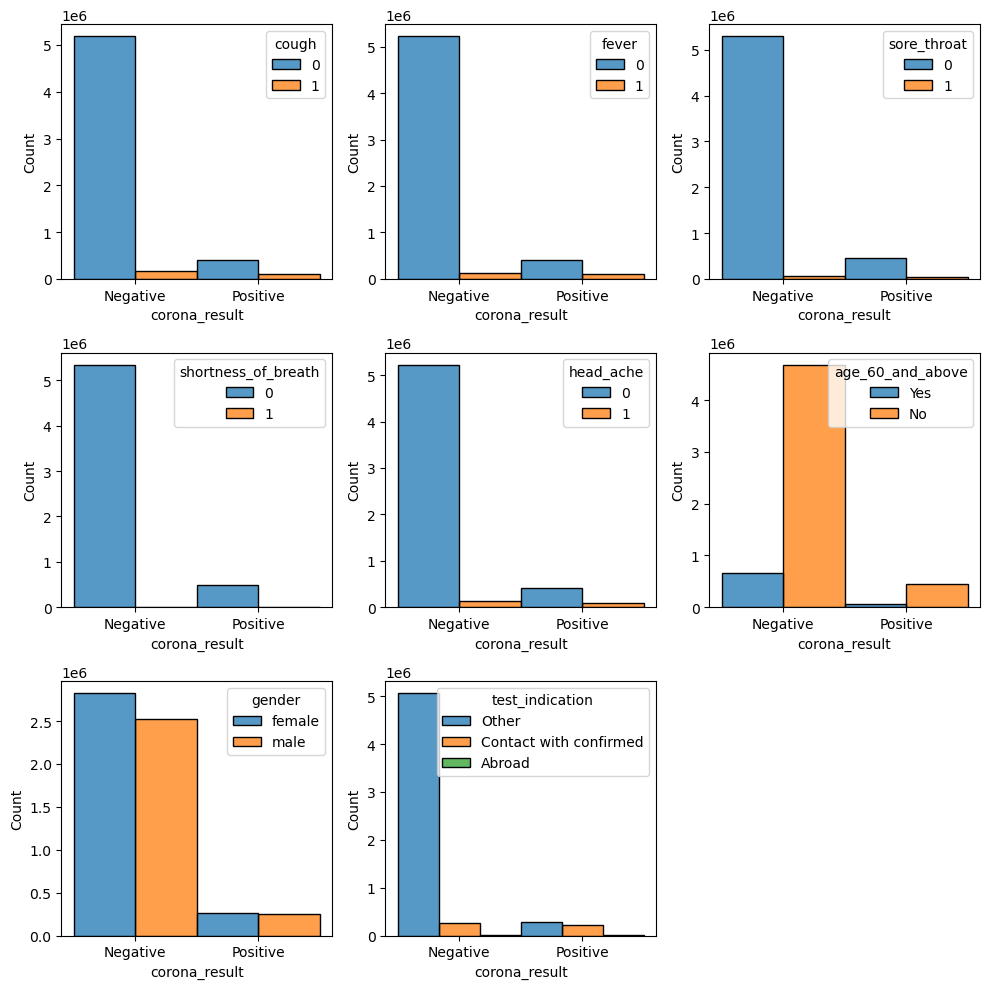

In [12]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)
ax7 = fig.add_subplot(3, 3, 7)
ax8 = fig.add_subplot(3, 3, 8)

sns.histplot(covid, x="corona_result", hue="cough", multiple="dodge", ax=ax1)
sns.histplot(covid, x="corona_result", hue="fever", multiple="dodge", ax=ax2)
sns.histplot(covid, x="corona_result", hue="sore_throat", multiple="dodge", ax=ax3)
sns.histplot(
    covid, x="corona_result", hue="shortness_of_breath", multiple="dodge", ax=ax4
)
sns.histplot(covid, x="corona_result", hue="head_ache", multiple="dodge", ax=ax5)
sns.histplot(covid, x="corona_result", hue="age_60_and_above", multiple="dodge", ax=ax6)
sns.histplot(covid, x="corona_result", hue="gender", multiple="dodge", ax=ax7)
sns.histplot(covid, x="corona_result", hue="test_indication", multiple="dodge", ax=ax8)

plt.tight_layout()
plt.show()

In [13]:
covid["shortness_of_breath"].value_counts()

shortness_of_breath
0    5834794
1      26686
Name: count, dtype: int64

## 전처리


In [14]:
# 범주형 특성의 원-핫 인코딩
cr_lbl = LabelEncoder()
age_lbl = LabelEncoder()
gender_lbl = LabelEncoder()
indi_one_hot = OneHotEncoder()

preprocessing_covid = covid.copy()

result = cr_lbl.fit_transform(covid.loc[:, "corona_result"])
preprocessing_covid.loc[:, "corona_result"] = result
print(preprocessing_covid["corona_result"].value_counts())

result = age_lbl.fit_transform(covid.loc[:, "age_60_and_above"])
preprocessing_covid.loc[:, "age_60_and_above"] = result
print(preprocessing_covid["age_60_and_above"].value_counts())

result = gender_lbl.fit_transform(covid.loc[:, "gender"])
preprocessing_covid.loc[:, "gender"] = result
print(preprocessing_covid["gender"].value_counts())

preprocessing_covid = pd.get_dummies(
    preprocessing_covid, dtype=int, columns=["test_indication"]
)

preprocessing_covid

corona_result
0    5355807
1     505673
Name: count, dtype: int64
age_60_and_above
0    5132888
1     728592
Name: count, dtype: int64
gender
0    3086361
1    2775119
Name: count, dtype: int64


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
0,2021-10-11,0,0,0,0,0,0,1,0,0,0,1
1,2021-10-11,0,0,0,0,0,0,1,1,0,0,1
2,2021-10-11,0,0,0,0,0,0,0,0,0,0,1
3,2021-10-11,0,0,0,0,0,0,1,0,0,0,1
4,2021-10-11,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5861475,2020-03-20,1,1,0,0,0,0,0,0,0,0,1
5861476,2020-03-20,0,0,0,0,0,0,0,1,0,0,1
5861477,2020-03-20,0,0,0,0,0,0,0,0,0,0,1
5861478,2020-03-20,0,0,0,0,0,0,0,1,0,0,1


In [15]:
negative_covid = preprocessing_covid[(preprocessing_covid.loc[:, 'cough'] == 0) &
                (preprocessing_covid.loc[:, 'fever'] == 0) &
                (preprocessing_covid.loc[:, 'sore_throat'] == 0) &
                (preprocessing_covid.loc[:, 'shortness_of_breath'] == 0) &
                (preprocessing_covid.loc[:, 'head_ache'] == 0)&
                (preprocessing_covid.loc[:, 'corona_result'] == 0)]

positive_covid = preprocessing_covid[(preprocessing_covid.loc[:, 'cough'] == 0) &
                (preprocessing_covid.loc[:, 'fever'] == 0) &
                (preprocessing_covid.loc[:, 'sore_throat'] == 0) &
                (preprocessing_covid.loc[:, 'shortness_of_breath'] == 0) &
                (preprocessing_covid.loc[:, 'head_ache'] == 0)&
                (preprocessing_covid.loc[:, 'corona_result'] == 1)]

wo_no_symt_negative = preprocessing_covid.drop(negative_covid.index)
wo_no_symt_positive = preprocessing_covid.drop(positive_covid.index)

wo_no_symt_all = preprocessing_covid.drop(negative_covid.index)
wo_no_symt_all = wo_no_symt_all.drop(positive_covid.index)

In [16]:
wo_no_symt_positive['corona_result'].value_counts()

corona_result
0    5355807
1     215420
Name: count, dtype: int64

## 상관관계 분석

In [17]:
corr_mat1 = preprocessing_covid.iloc[:, 1:].corr()
corr_mat2 = wo_no_symt_negative.iloc[:, 1:].corr()
corr_mat3 = wo_no_symt_positive.iloc[:, 1:].corr()
corr_mat4 = wo_no_symt_all.iloc[:, 1:].corr()

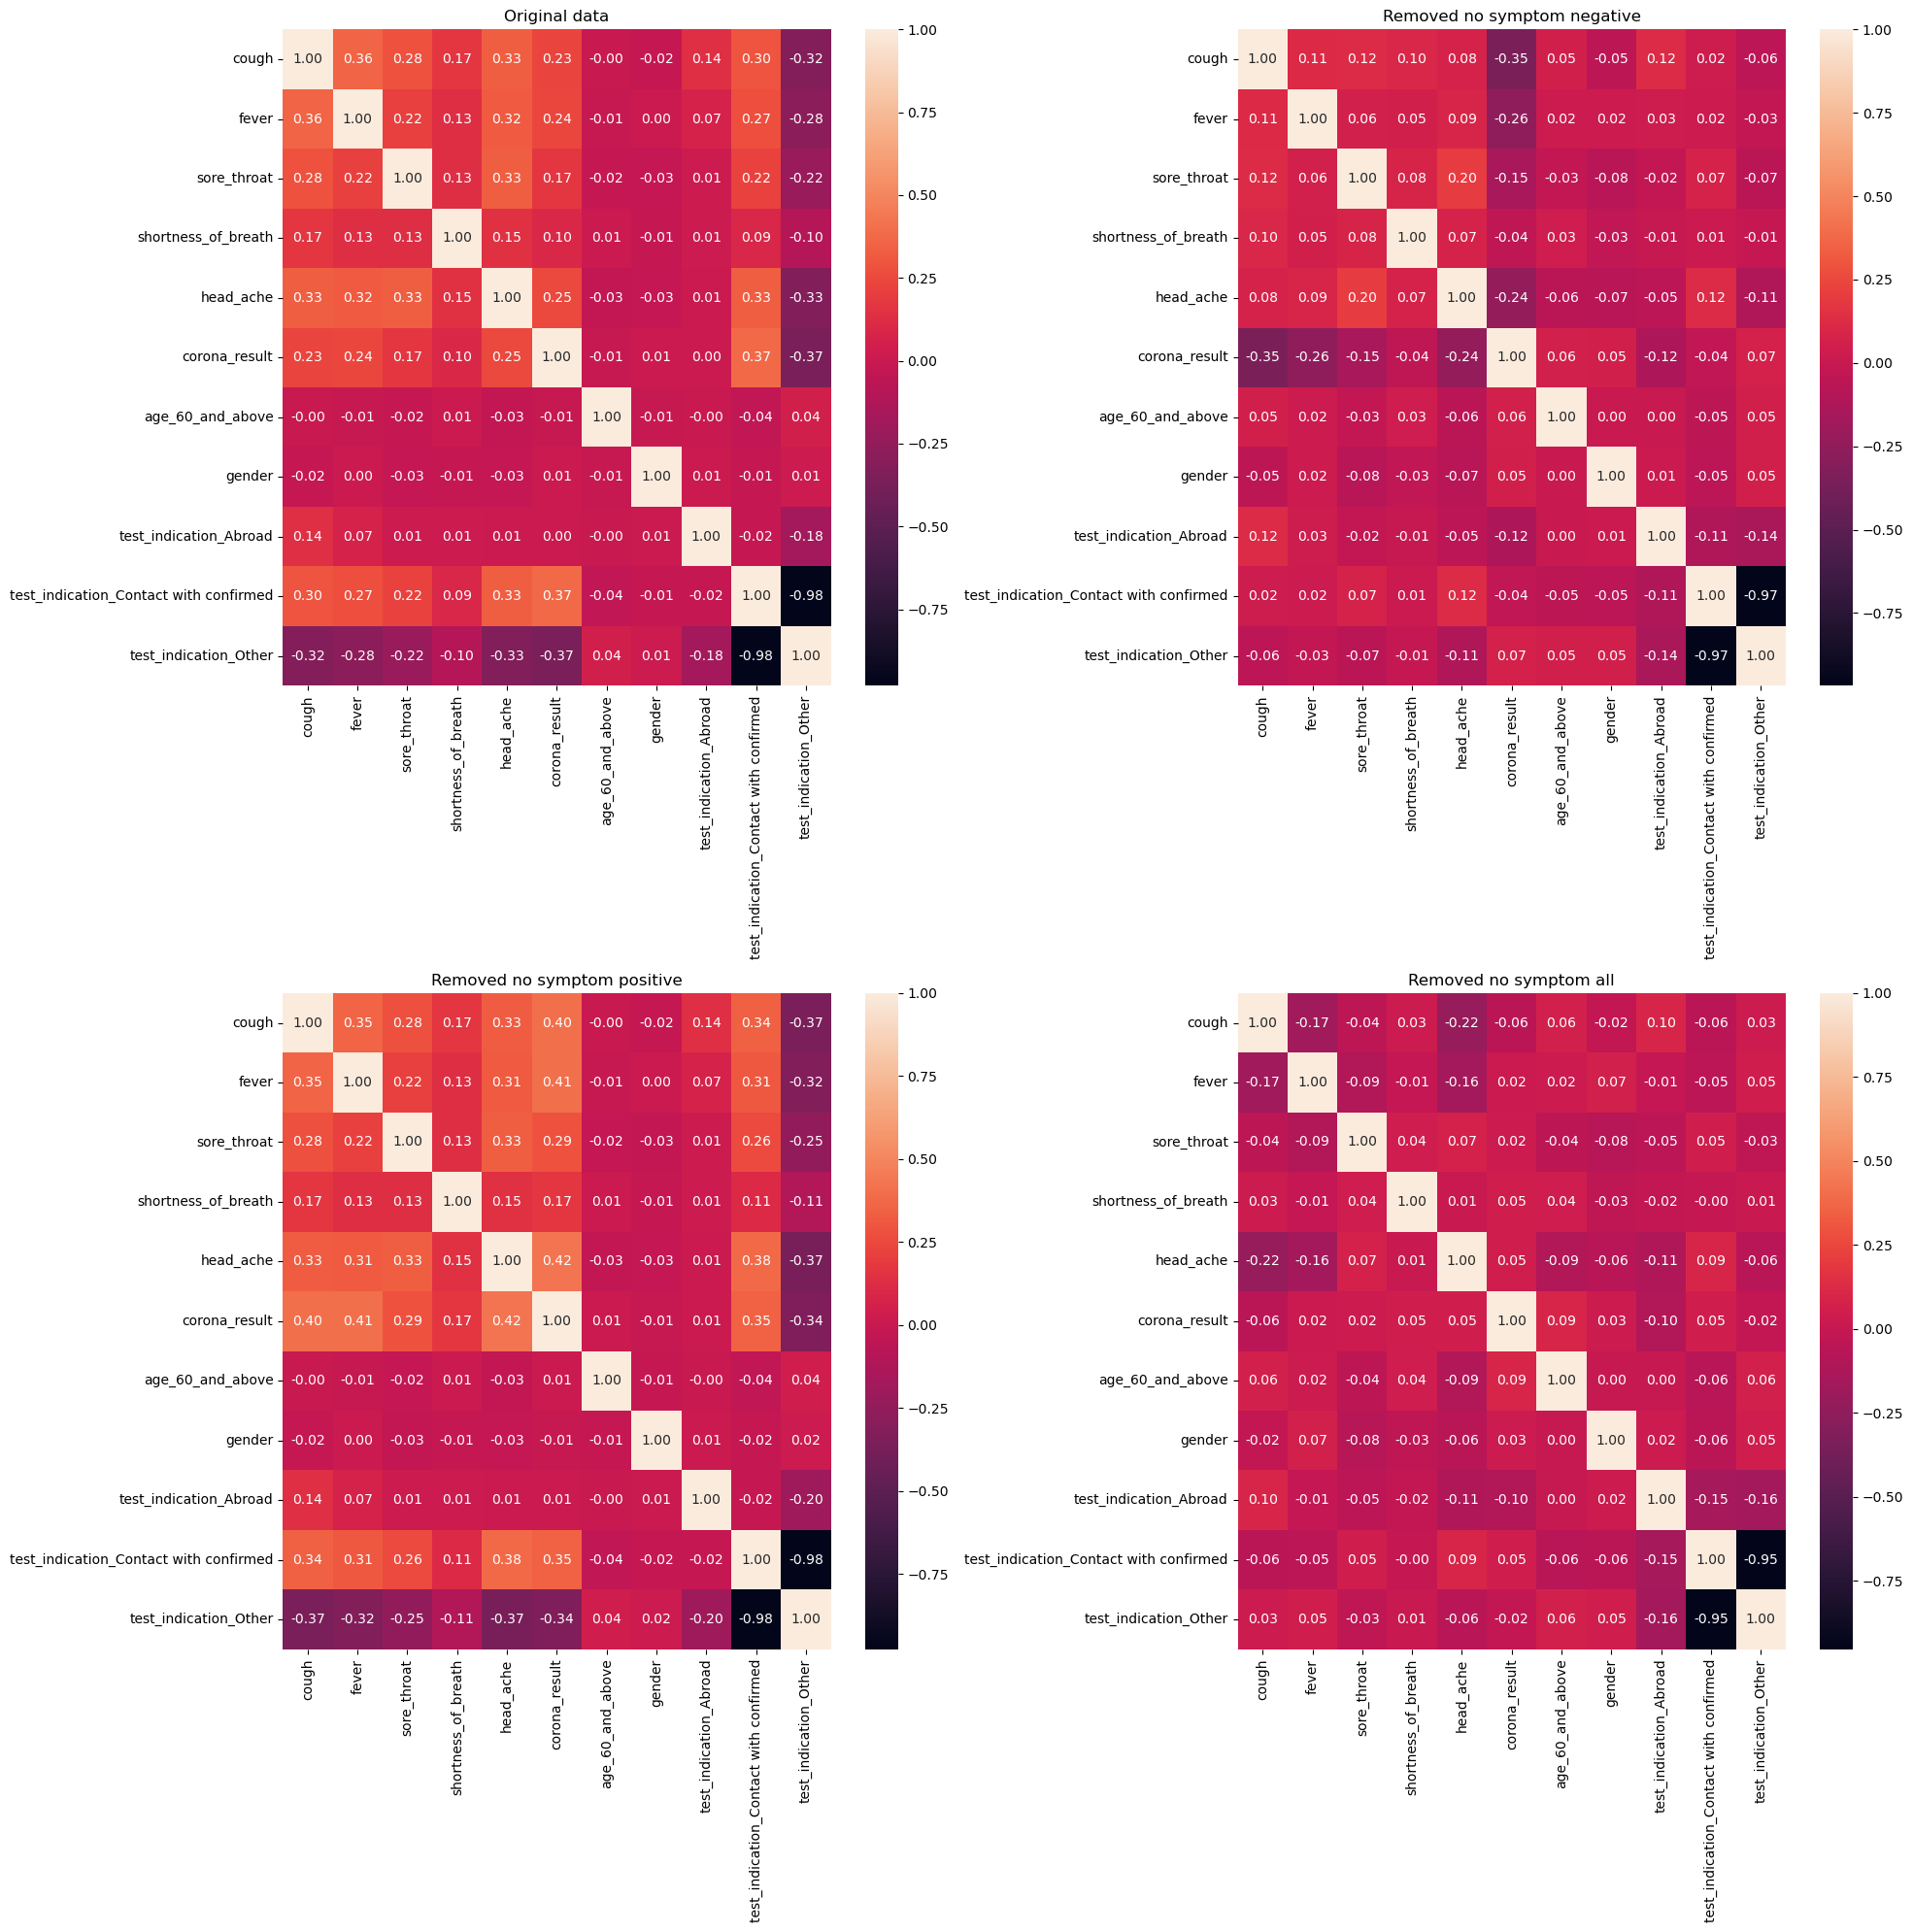

In [18]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.heatmap(corr_mat1, annot=True, fmt=".2f", ax=ax1)
sns.heatmap(corr_mat2, annot=True, fmt=".2f", ax=ax2)
sns.heatmap(corr_mat3, annot=True, fmt=".2f", ax=ax3)
sns.heatmap(corr_mat4, annot=True, fmt=".2f", ax=ax4)

ax1.set_title("Original data")
ax2.set_title("Removed no symptom negative")
ax3.set_title("Removed no symptom positive")
ax4.set_title("Removed no symptom all")
plt.tight_layout()
plt.show()

In [19]:
data = wo_no_symt_positive.loc[:, ['cough', 'fever', 'sore_throat',
                            'shortness_of_breath', 'head_ache', 'test_indication_Contact with confirmed']]
target = wo_no_symt_positive.loc[:, ['corona_result']]
target = target.astype(int)

## 언더 샘플링

In [20]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(data, target)
y_under.value_counts()
y_under.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430840 entries, 2508188 to 5861256
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   corona_result  430840 non-null  int32
dtypes: int32(1)
memory usage: 4.9 MB


## train_test 데이터 시각화

In [69]:
negative_positive = {0: 'Negative', 1:'Positive'}

In [84]:
xy_data = pd.concat([X_under, y_under], axis=1)
xy_data['corona_result'] = xy_data['corona_result'].apply(lambda x : negative_positive[x])

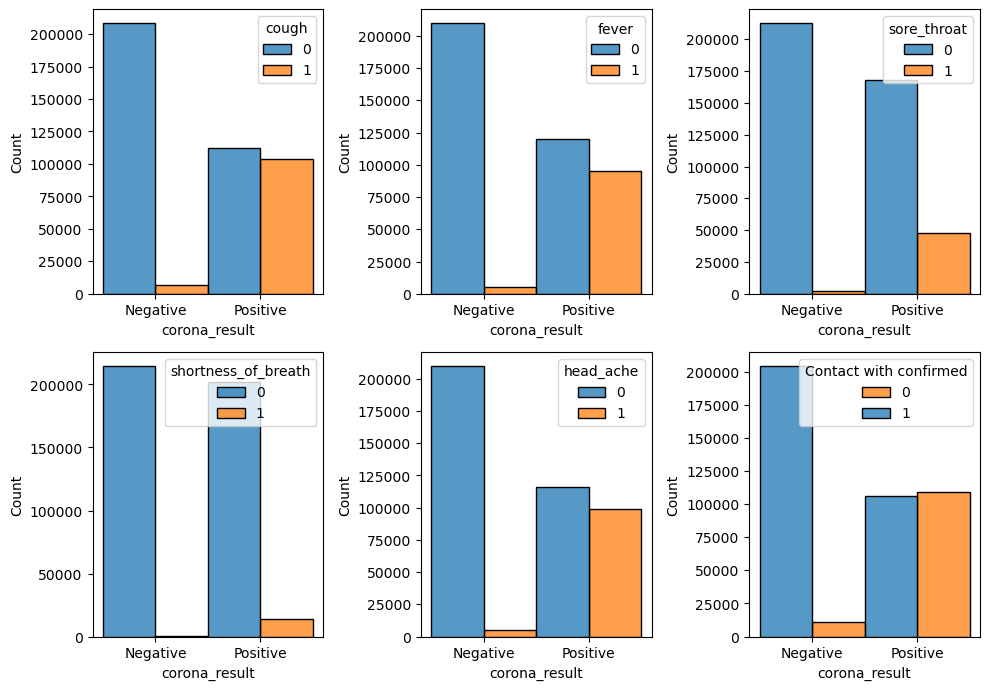

In [83]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)

sns.histplot(xy_data, x="corona_result", hue="cough", multiple="dodge", ax=ax1, bins=[0,1])
sns.histplot(xy_data, x="corona_result", hue="fever", multiple="dodge", ax=ax2)
sns.histplot(xy_data, x="corona_result", hue="sore_throat", multiple="dodge", ax=ax3)
sns.histplot(
    xy_data, x="corona_result", hue="shortness_of_breath", multiple="dodge", ax=ax4
)
sns.histplot(xy_data, x="corona_result", hue="head_ache", multiple="dodge", ax=ax5)
sns.histplot(xy_data, x="corona_result", hue="test_indication_Contact with confirmed", multiple="dodge", ax=ax6)

ax6.legend(title="Contact with confirmed", labels=[0, 1])
plt.tight_layout()
plt.show()

## 데이터 분리

In [21]:
y_under = y_under.reset_index(drop=True)
X_under = X_under.reset_index(drop=True)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.1, stratify=y_under)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

In [23]:
print(x_train.shape, x_test.shape)

(387756, 6) (43084, 6)


## 모델 학습

In [24]:
logi = LogisticRegression(max_iter=500)
tree = DecisionTreeClassifier()

In [25]:
models = [('ada', AdaBoostClassifier(logi)),
          ('bc', BaggingClassifier(tree)),
          ('rfc', RandomForestClassifier()),
          ('knn', KNeighborsClassifier()),
          ('xgb', XGBClassifier()),
          ('lgbm', LGBMClassifier()),
          ('dtc', DecisionTreeClassifier()),
          ('logi', LogisticRegression())]
vote = VotingClassifier(models, voting='soft')
vote.fit(x_train.values, y_train['corona_result'].values)

[LightGBM] [Info] Number of positive: 193878, number of negative: 193878
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 387756, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(estimator=LogisticRegression(max_iter=500))),
                             ('bc',
                              BaggingClassifier(estimator=DecisionTreeClassifier())),
                             ('rfc', RandomForestClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytre...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lgbm', LGBMClassifier()),
                             ('dtc', DecisionTreeClassifier()),
                             ('logi', LogisticRegression())],
                 voting='soft')

### 트레인 셋 예측

In [26]:
pred = vote.predict(x_train.values)

In [27]:
acc_score = accuracy_score(y_train['corona_result'].values, pred)
f1score = f1_score(y_train['corona_result'].values, pred)
acc_score, f1score

(0.9706103838496374, 0.9714494728825108)

### 테스트 셋 예측

In [28]:
pred = vote.predict(x_test.values)

In [29]:
proba = vote.predict_proba(x_test.values)

In [30]:
pd.DataFrame(pred).value_counts()

1    22848
0    20236
Name: count, dtype: int64

In [31]:
y_test.value_counts()

corona_result
0                21542
1                21542
Name: count, dtype: int64

### 성능평가

In [32]:
acc_score = accuracy_score(y_test,pred)
f1score = f1_score(y_test, pred)
acc_score, f1score

(0.9696871228298208, 0.9705789592250507)

In [33]:
confusion_matrix(y_test,pred)

array([[20236,  1306],
       [    0, 21542]], dtype=int64)

In [34]:
proba[:,1].shape

(43084,)

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

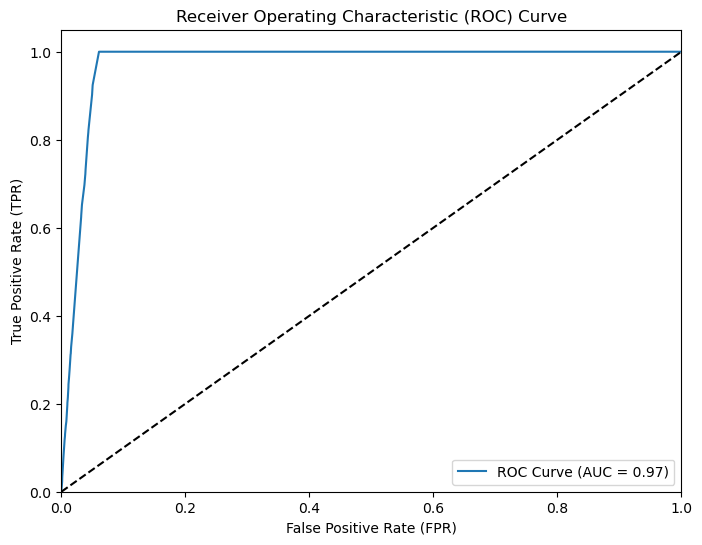

In [36]:
# TPR, FPR, 임계값 계산
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])

# ROC curve 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, proba[:,1])))
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 분류 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## MLP 예측

In [38]:
model = MLPClassifier(max_iter=1000) # w1: 2x100, w2:100x1
model.fit(x_train.values, y_train.values)

C:\Users\medici\miniconda3\envs\math_stats\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(max_iter=1000)

In [39]:
pred2 = model.predict(x_test)
pred2

C:\Users\medici\miniconda3\envs\math_stats\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 0, ..., 0, 1, 0])

In [40]:
acc_score = accuracy_score(y_test,pred2)
f1score = f1_score(y_test, pred2)
acc_score, f1score

(0.9696871228298208, 0.9705789592250507)

In [49]:
model2 = MLPClassifier(hidden_layer_sizes=(64,32), max_iter = 1000)
model2.fit(x_train.values, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000)

In [50]:
pred3 = model2.predict(x_test)
pred3

C:\Users\medici\miniconda3\envs\math_stats\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 0, ..., 0, 1, 0])

In [51]:
acc_score = accuracy_score(y_test,pred3)
f1score3 = f1_score(y_test, pred3)
acc_score, f1score

(0.9696871228298208, 0.9705789592250507)

## 시계열 분석

In [85]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5861480 entries, 0 to 5861479
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   test_date            datetime64[ns]
 1   cough                int64         
 2   fever                int64         
 3   sore_throat          int64         
 4   shortness_of_breath  int64         
 5   head_ache            int64         
 6   corona_result        object        
 7   age_60_and_above     object        
 8   gender               object        
 9   test_indication      object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 447.2+ MB


In [ ]:
time_covid = covid.loc[:, ['test_date', 'corona_resu